# ОПИСАНИЕ ЗАДАЧИ

Данные:
- чековые данные (transactions.parquet, для чтения через pandas дополнительно нужно установить библиотеку pyarrow)
- справочник товаров (materials.csv)
- справочник магазинов (plants.csv)
- справочник клиентов (clients.csv)
Более подробное описание данных дано в файле Data Description.

Цель: 
1) проанализировать данные и определить оптимальную методологию определения отточных клиентов
2) разработать модель вероятности оттока клиентов по выбранной вами методологии
3) дать интерпретацию разработанной модели, ответить на вопросы: какие признаки наиболее влияют на отток клиентов


# ЧАСТЬ 5. Создание модели

### Загрузка библиотек

In [15]:
import pandas as pd
from pathlib import Path
import numpy as np
import pickle
import gc
from statistics import mode
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import  SVC
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn import metrics

# 1. Загрузка данных

In [3]:
workdir = str(Path().absolute())

In [4]:
data = pd.read_pickle(workdir+'/data/data_done.pkl')

Посмотрим на данные.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 36598170 entries, (56437, 2016-10-04 00:00:00) to (33413, 2017-10-04 00:00:00)
Columns: 148 entries, chq_count to is_price_discount_1m
dtypes: float32(1), float64(2), int16(116), int64(14), int8(15)
memory usage: 13.1 GB


### Разделение на train-test

## _ПРИМЕЧАНИЕ: В связи с низкой мощностью аппаратных ресурсов обучение моделей будет выполнено на первых 5 000 клиентах. Тестирование будет выполнено для всех клиентов с данными за последний день наблюдений (2017-20-04)._

In [6]:
X_train = data.query("(chq_date != '2017-10-04') & (client_id < 5000)").drop(columns='is_churn')
y_train = data.query("(chq_date != '2017-10-04') & (client_id < 5000)")[['is_churn']]

X_test = data.query("chq_date == '2017-10-04'").drop(columns='is_churn')
y_test = data.query("chq_date == '2017-10-04'")[['is_churn']]

# 2. Model Selection

### Полезные функции

In [7]:
def cross_validation(model,xtrain,ytrain, scoretype, folds):
    tss = TimeSeriesSplit(max_train_size=None, n_splits=folds)
    scores = cross_val_score(estimator = model,X= xtrain, y = ytrain,scoring = scoretype,cv = tss)
           
def roc_curve(X_test,y_test,model,model_name):
    roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    fpr,tpr,threshold = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label = "Model:" + model_name +(" (AUC) = %0.2f")%roc_auc)
    plt.plot([0,1],[0,1],"r--")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.show()

### Прогон моделей с базовыми параметрами

In [8]:
SEED = 42

Оценка модели AdaBoost Classifier:
Fit...DONE
Cross-validation...DONE


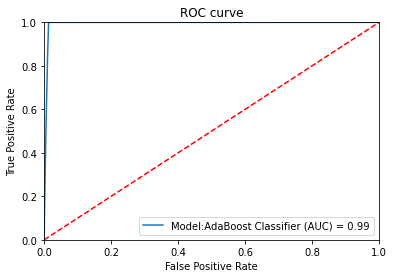

Оценка модели Bagging Classifier:
Fit...DONE
Cross-validation...DONE


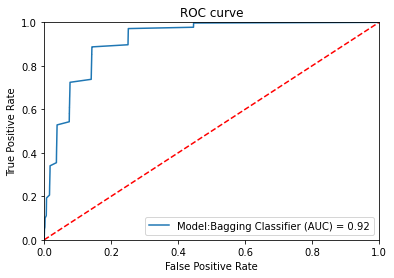

Оценка модели Gradient Boosting Classifier:
Fit...DONE
Cross-validation...DONE


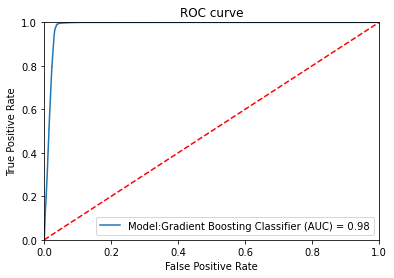

Оценка модели Random Forest Classifier:
Fit...DONE
Cross-validation...DONE


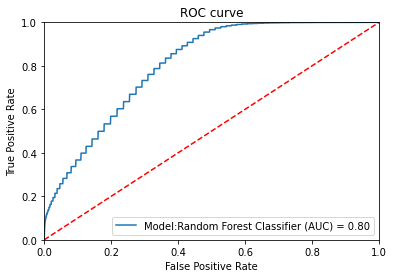

Оценка модели Decision Tree Classifier:
Fit...DONE
Cross-validation...DONE


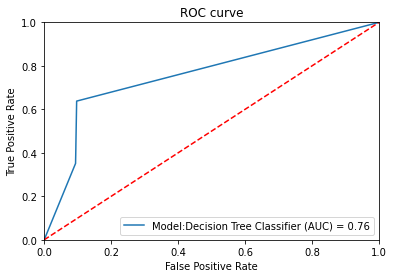

Оценка модели KNeighbors Classifier:
Fit...DONE
Cross-validation...DONE


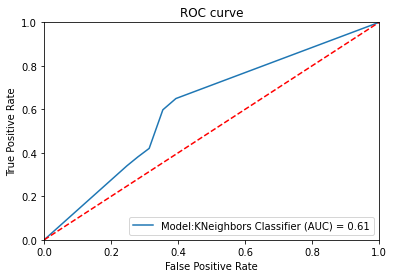

Оценка модели Logistic Regression:
Fit...DONE
Cross-validation...DONE


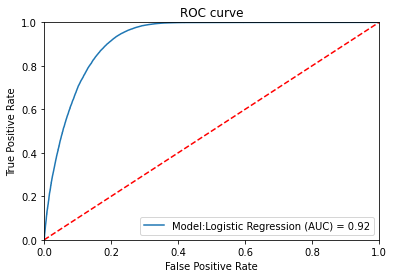

In [9]:
models = [AdaBoostClassifier(random_state=SEED),
BaggingClassifier(random_state=SEED), 
GradientBoostingClassifier(random_state=SEED), 
RandomForestClassifier(random_state=SEED),
DecisionTreeClassifier(random_state=SEED),
KNeighborsClassifier(),
LogisticRegression(random_state=SEED), 
         ]

modelnames = ['AdaBoost Classifier', 
'Bagging Classifier', 
'Gradient Boosting Classifier', 
'Random Forest Classifier',
'Decision Tree Classifier',
'KNeighbors Classifier',
'Logistic Regression', 
]

for currmodel, modelname in zip(models, modelnames):
    print(f"Оценка модели {modelname}:")
    print("Fit...", end="")
    model = currmodel
    model.fit(X_train, y_train)
    print("DONE")
    print("Cross-validation...", end="")
    cross_validation(model, X_train, y_train, scoretype = "roc_auc", folds = 4)
    print("DONE")
    roc_curve(X_test, y_test, model, modelname)

Наилучший Score у моделей AdaBoost, Gradient Boosting, Logistic Regression и Bagging Classifier. Обучим-протестируем некоторые из них и посмотрим на предсказания вероятностей.

# 3. AdaBoost

### Подбор оптимальных гиперпараметров

Предполагалось выполнить подбор гиперпараметров с использованием RandomizedSearchCV. Однако, в связи с нехваткой времени и мощности аппаратных ресурсов, было принято решение пропустить этот этап. К тому же score=0.99 на обучающем этапе с базовыми гиперпараметрами является очень высоким.

### Обучение модели

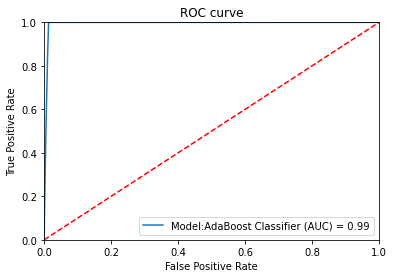

In [11]:
model = AdaBoostClassifier(random_state=SEED)
model.fit(X_train, y_train)
cross_validation(model, X_train, y_train, scoretype = "roc_auc", folds = 4)
roc_curve(X_test, y_test, model, 'AdaBoost Classifier')

### Предсказание вероятностей

In [33]:
model.classes_

array([0, 1], dtype=int8)

In [35]:
predict_proba = model.predict_proba(X_test)

### Анализ правдоподобности полученных вероятностей

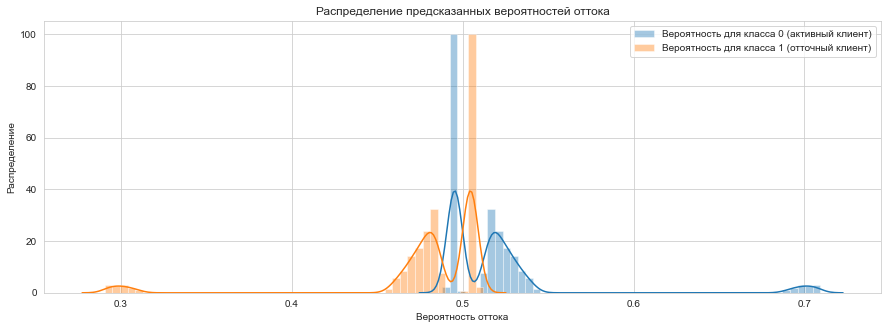

In [36]:
plt.figure(figsize=(15,5))

g = sns.distplot(predict_proba[:,0], label='Вероятность для класса 0 (активный клиент)')
g = sns.distplot(predict_proba[:,1], label='Вероятность для класса 1 (отточный клиент)')

g.set_title("Распределение предсказанных вероятностей оттока")
g.set_xlabel('Вероятность оттока')
g.set_ylabel('Распределение')
g.legend()
plt.show()

Большинство вероятностей сосредоточены возле "границы неопределенности" 0.5. Причем верхняя граница вероятности для класса 1 (отточный пользователь) едва выше границы 0.5. Это наводит на мысль о слабой определенности предсказаний.

Посмотрим визуально насколько выражена разница между вероятностями принадлежности к классам.

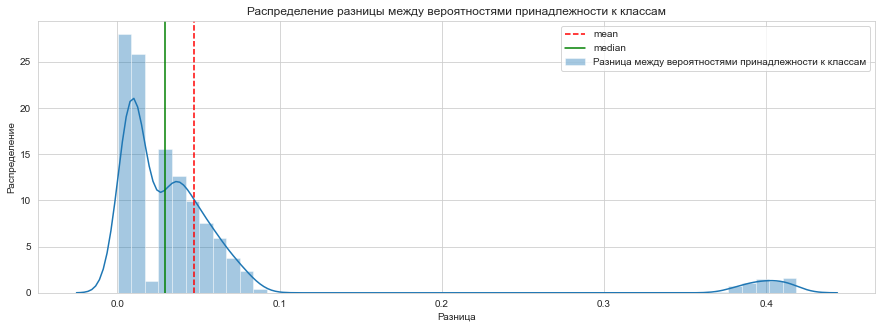

In [66]:
plt.figure(figsize=(15,5))

g = sns.distplot(abs(predict_proba[:,0]-predict_proba[:,1]), label='Разница между вероятностями принадлежности к классам')
mean=np.mean(abs(predict_proba[:,0]-predict_proba[:,1]))
median=np.median(abs(predict_proba[:,0]-predict_proba[:,1]))

plt.axvline(mean, color='r', linestyle='--', label='mean')
plt.axvline(median, color='g', linestyle='-', label='median')

g.set_title("Распределение разницы между вероятностями принадлежности к классам")
g.set_xlabel('Разница')
g.set_ylabel('Распределение')
g.legend()
plt.show()

In [64]:
good_preds = (abs(predict_proba[:,0]-predict_proba[:,1]))
good_preds_rate = len([x for x in good_preds if x >= 0.5])/len(predict_proba)
print(f"Доля разниц в предсказаниях разных классов выше порога 0.5: {good_preds_rate:.2f}")

Доля разниц в предсказаниях разных классов выше порога 0.5: 0.00


Действительно, большинство предсказаний имеют очень слабую силу. Сильно выраженных предсказаний (разница между классами выше порога в 0.5) - нет.

_Вывод:_ 
_* данная модель дала слабо выраженные предсказания._

# 4. Gradient Boosting Classifier

### Подбор оптимальных гиперпараметров

Предполагалось выполнить подбор гиперпараметров с использованием RandomizedSearchCV. Однако, в связи с нехваткой времени и мощности аппаратных ресурсов, было принято решение пропустить этот этап. К тому же score=0.98 на обучающем этапе с базовыми гиперпараметрами является очень высоким.

### Обучение модели

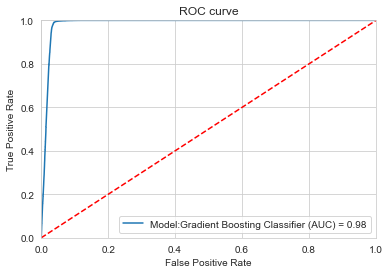

In [22]:
model_gbm = GradientBoostingClassifier(random_state=SEED)
model_gbm.fit(X_train, y_train)
cross_validation(model_gbm, X_train, y_train, scoretype = "roc_auc", folds = 4)
roc_curve(X_test, y_test, model_gbm, 'Gradient Boosting Classifier')

### Предсказание вероятностей

In [32]:
model_gbm.classes_

array([0, 1], dtype=int8)

In [38]:
predict_proba_gbm = model_gbm.predict_proba(X_test)

### Анализ правдоподобности полученных вероятностей

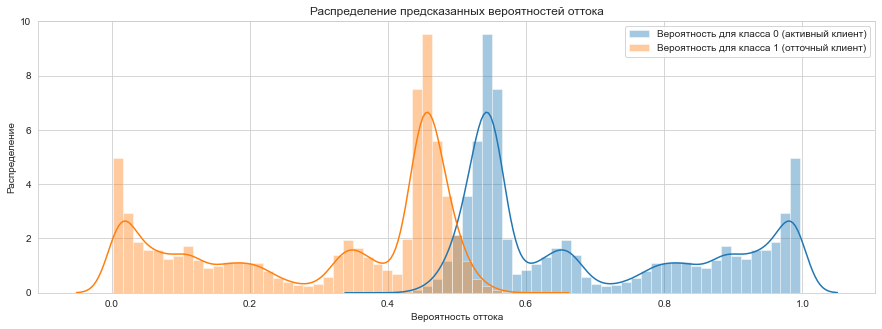

In [39]:
plt.figure(figsize=(15,5))

g = sns.distplot(predict_proba_gbm[:,0], label='Вероятность для класса 0 (активный клиент)')
g = sns.distplot(predict_proba_gbm[:,1], label='Вероятность для класса 1 (отточный клиент)')

g.set_title("Распределение предсказанных вероятностей оттока")
g.set_xlabel('Вероятность оттока')
g.set_ylabel('Распределение')
g.legend()
plt.show()

Здесь значительная часть предсказаний как и в предыдущей модели тяготеет к "границе неопределенности 0.5. И верхняя граница вероятности для класса 1 (отточный пользователь) также едва выше границы 0.5.  Однако, модель справилась лучше предыдущей, так как вероятности принадлежности к разным классам более различимы.

Посмотрим визуально насколько выражена разница между вероятностями принадлежности к классам.

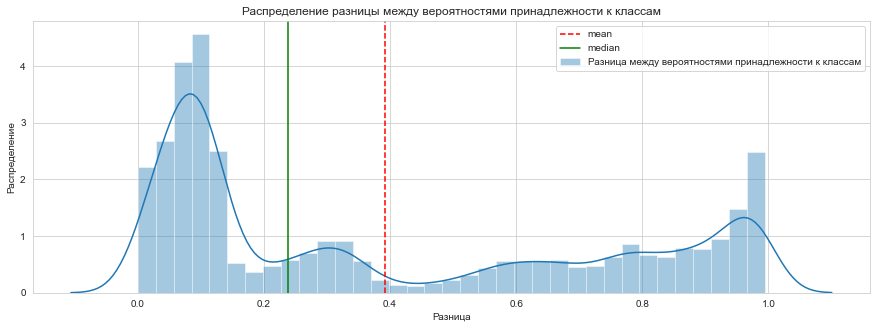

In [65]:
plt.figure(figsize=(15,5))

g = sns.distplot(abs(predict_proba_gbm[:,0]-predict_proba_gbm[:,1]), label='Разница между вероятностями принадлежности к классам')
mean=np.mean(abs(predict_proba_gbm[:,0]-predict_proba_gbm[:,1]))
median=np.median(abs(predict_proba_gbm[:,0]-predict_proba_gbm[:,1]))

plt.axvline(mean, color='r', linestyle='--', label='mean')
plt.axvline(median, color='g', linestyle='-', label='median')

g.set_title("Распределение разницы между вероятностями принадлежности к классам")
g.set_xlabel('Разница')
g.set_ylabel('Распределение')
g.legend()
plt.show()

In [63]:
good_preds_gbm = (abs(predict_proba_gbm[:,0]-predict_proba_gbm[:,1]))
good_preds_gbm_rate = len([x for x in good_preds_gbm if x >= 0.5])/len(predict_proba_gbm)
print(f"Доля разниц в предсказаниях разных классов выше порога 0.5: {good_preds_gbm_rate:.2f}")

Доля разниц в предсказаниях разных классов выше порога 0.5: 0.38


Слабо различимых предсказаний принадлежности к разным классам все также много. Однако в данной модели намного больше хорошо различимых вероятностей, чем у предыдущей. Их доля составляет 0.38 от всех предсказаний.

_Вывод:_
_* данная модель справилась лучше предыдущей. Вероятности принадлежности к разным классам более выражены, и следовательно, более правдоподобны._

# 5. Logistic Regression

### Подбор оптимальных гиперпараметров

Предполагалось выполнить подбор гиперпараметров с использованием RandomizedSearchCV. Однако, в связи с нехваткой времени и мощности аппаратных ресурсов, было принято решение пропустить этот этап. К тому же score=0.99 на обучающем этапе с базовыми гиперпараметрами является очень высоким.

### Обучение модели

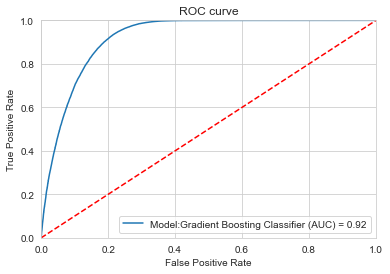

In [25]:
model_lrm = LogisticRegression(random_state=SEED)
model_lrm.fit(X_train, y_train)
cross_validation(model_lrm, X_train, y_train, scoretype = "roc_auc", folds = 4)
roc_curve(X_test, y_test, model_lrm, 'Gradient Boosting Classifier')

### Предсказание вероятностей

In [34]:
model_lrm.classes_

array([0, 1], dtype=int8)

In [42]:
predict_proba_lrm = model_lrm.predict_proba(X_test)

### Анализ правдоподобности полученных вероятностей

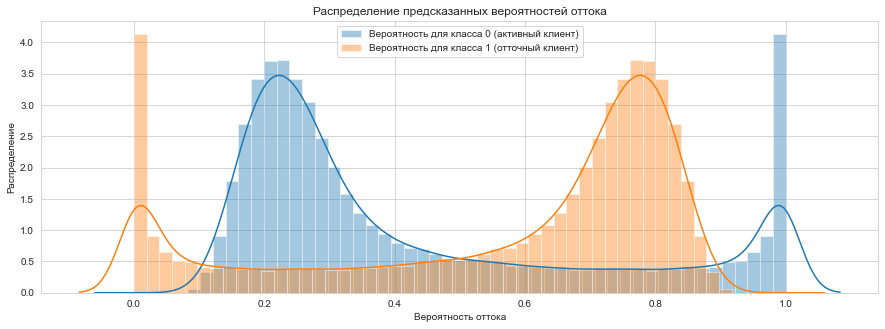

In [43]:
plt.figure(figsize=(15,5))

g = sns.distplot(predict_proba_lrm[:,0], label='Вероятность для класса 0 (активный клиент)')
g = sns.distplot(predict_proba_lrm[:,1], label='Вероятность для класса 1 (отточный клиент)')

g.set_title("Распределение предсказанных вероятностей оттока")
g.set_xlabel('Вероятность оттока')
g.set_ylabel('Распределение')
g.legend()
plt.show()

Вероятности принадлежности к классам у данной модели выглядят намного лучше, чем у предыдущих моделей. Видно, что большинство предсказаний для класса 1 (отточный пользователь) очень уверенные (~0.7-0.9). 

Посмотрим визуально насколько выражена разница между вероятностями принадлежности к классам.

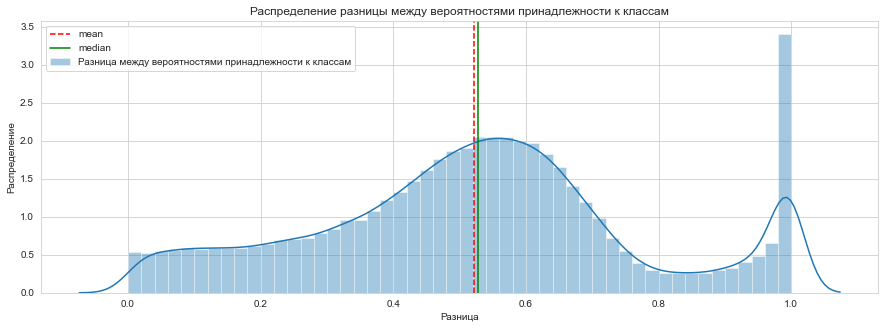

In [62]:
plt.figure(figsize=(15,5))

g = sns.distplot(abs(predict_proba_lrm[:,0]-predict_proba_lrm[:,1]), label='Разница между вероятностями принадлежности к классам')
mean=np.mean(abs(predict_proba_lrm[:,0]-predict_proba_lrm[:,1]))
median=np.median(abs(predict_proba_lrm[:,0]-predict_proba_lrm[:,1]))

plt.axvline(mean, color='r', linestyle='--', label='mean')
plt.axvline(median, color='g', linestyle='-', label='median')

g.set_title("Распределение разницы между вероятностями принадлежности к классам")
g.set_xlabel('Разница')
g.set_ylabel('Распределение')
g.legend()
plt.show()

In [61]:
good_preds_lrm = (abs(predict_proba_lrm[:,0]-predict_proba_lrm[:,1]))
good_preds_lrm_rate = len([x for x in good_preds_lrm if x >= 0.5])/len(predict_proba_lrm)
print(f"Доля разниц в предсказаниях разных классов выше порога 0.5: {good_preds_lrm_rate:.2f}")

Доля разниц в предсказаниях разных классов выше порога 0.5: 0.55


Действительно, большинство предсказаний у этой модели "уверенные" и хорошо различимые. Модель, в основном, разделяет на классы с хорошо различимой разницей между вероятностями (выше порога разницы в 0.5).

_Вывод:_
* _несмотря на самый низкий Score среди отобранных моделей (0.92), данная модель дает самые ярко выраженные предсказания вероятностей. Вероятности разделения на классы у этой модели наиболее правдоподобные. Поэтому данная модель выбрана лучшей._

# 6. Анализ полученных результатов

### Лучшие признаки для определения оттока клиентов

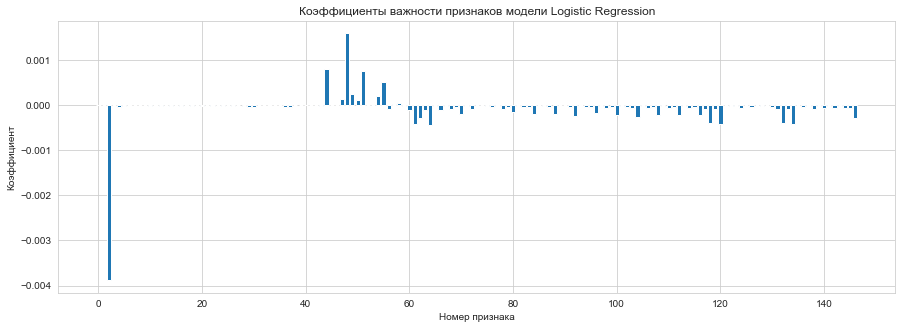

In [82]:
plt.figure(figsize=(15,5))

importance_chart = model_lrm.coef_[0]
plt.bar([x for x in range(len(importance_chart))], importance_chart)

plt.title("Коэффициенты важности признаков модели Logistic Regression")
plt.xlabel('Номер признака')
plt.ylabel('Коэффициент')
plt.show()

In [79]:
features = [i for i in X_train.columns if i != "is_churned"]
importance = pd.DataFrame({'Признак': features, 'Importance': model_lrm.coef_[0]}).sort_values('Importance',ascending = False)
importance[importance['Importance']>0]

,Признак,Importance
48,best_by_sum_cat3,0.001586
44,best_by_sum_plnt,0.000794
51,best_by_cnt_plnt,0.000755
55,best_by_cnt_cat3,0.000518
49,best_by_sum_cat4,0.000246
54,best_by_cnt_cat2,0.000188
47,best_by_sum_cat2,0.000137
50,best_by_sum_vndr,0.000117
58,week,0.000033
57,best_by_cnt_vndr,0.000032


Признаки, давшие заметный вклад в предсказания, отсутствуют. 

Вклады признаков в предсказания выбранной модели оказались неожиданными. Модель выбрала "отточных" клиентов не по их активности в течение месяца, а по их личным предпочтениям. Это означает, что клиенты, имеющие предпочтения в определенных товарах, или их категориях, или производителях, хорошо определяются как отточные. Это наводит на мысль, что клиенты могут уходить, не имея возможности покупать товары любимых категорий или производителей.   

* best_by_sum_cat3. Coef = 0.001586. Самый популярный тип товара в категории 3 у клиента по общей сумме его покупок. Данный признак оказался самым эффективным в предсказании вероятности оттока. Мониторинг покупок самого популярного товара клиента в категории 3 дает наиболее важен для данной модели.  
* best_by_sum_plnt. Coef = 	0.000794. Самый популярный магазин клиента по общей сумме покупок. Важность данного признака вызывает сомнение. В выборке есть магазины с небольшим количеством клиентов. Поэтому нельзя сказать с уверенностью, что какие-то из магазинов влияют на отток клиентов.
* best_by_cnt_plnt. Coef = 	0.000755. Самый популярный магазин клиента по количеству покупок. Важность данного признака вызывает сомнение. В выборке есть магазины с небольшим количеством клиентов. Поэтому нельзя сказать с уверенностью, что какие-то из магазинов влияют на отток клиентов.
* best_by_cnt_cat3. Coef = 	0.000518. Самый популярный тип товара в категории 3 у клиента по общему количеству появлений в его чеках.
* best_by_sum_cat4. Coef = 	0.000246. Самый популярный тип товара в категории 4 у клиента по общей сумме его покупок.
* best_by_cnt_cat2. Coef = 	0.000188. Самый популярный тип товара в категории 2 у клиента по общему количеству появлений в его чеках.
* best_by_sum_cat2. Coef = 	0.000137. Самый популярный тип товара в категории 2 у клиента по общей сумме его покупок.
* best_by_sum_vndr. Coef = 	0.000117
* week. Coef = 	0.000033. Номер недели оказался среди признаков, сделавших вклад в предсказание. Это наводит на мысль, что в определенные недели были ярко выраженные факты активности или оттока клиентов. К сожалению, невозможно проверить, что данные явления имеют сезонный характер, или являются результатом какой-нибудь активности компании.
* best_by_cnt_vndr. Coef = 	0.000032. Самый популярный производитель у клиента по общему количеству появлений в его чеках.
* best_by_sum_mtrl. Coef = 	0.000003. Самый популярный товар клиента по общей сумме его покупок.

### Выбор оптимального соотношения True Positive и False Negative

Поскольку задача состоит в том, чтобы корректно идентифицировать отточных клиентов, требуется максимизировать получение True Positive результатов классификации. Мы можем исключить False Positive ошибки (клиенты, которые, были классифицированы отточными, но этого не произошло), поскольку они не так важны. Кроме того, требуется минимизировать False Negative ошибку (клиенты, которые, были классифицированы как активные, но они ушли). В этом случае мы можем потерять этих клиентов из-за ошибки.

За основу взято решение по анализу предсказанного оттока посредством COST-функции:

https://github.com/pareshg18/Predicting-Customer-Churn/blob/master/Customer-Churn-Prediction.ipynb

В данной функции используются долларовые расчеты стоимости стимуляции клиентов в западных компаниях. В российских компаниях могут быть другие финансовые показатели. Однако, в связи отсутствия такой информации по РФ, придется пренебречь этой возможной разницей. Просто преобразуем COST-функцию в рублевый вариант по курсу 90 руб. за доллар.

_Описание решения:_

    Чтобы получить наилучшие возможные прогнозы, нам нужно выбрать оптимальный порог.

    Поскольку это проблема двоичной классификации, у нас есть 4 возможных результата (TP, TN, FP и FN), и в бизнесе все 4 связаны с затратами. Поскольку порог влияет на все 4 результата, необходимо определить стоимость (COST) для каждого из них.

    Сделаем некоторые предположения:

    * Во-первых, стоимость True Negative (TN) будет равна 0. Этот результат по сути означает, что мы правильно определили клиентов, которые НЕ собираются уходить, и, следовательно, нам не нужно ничего делать.
    * False Negative (TN) результаты - самая большая проблема для нас. Это те клиенты, которых мы неверно предсказали, поскольку они не уйдут. Мы теряем этих клиентов, так как здесь мы не будем предпринимать никаких действий, и, следовательно, нам придется оплатить все расходы по привлечению нового клиента (включая доходы, расходы на рекламу, административные расходы, расходы на торговые точки и т.д.). Поиск показал, что такие затраты различаются для каждой компании, но компаниям, занимающимся карьерой, требуется около 70 долларов (около 6300 руб.), чтобы привлечь нового клиента.
    * Наконец, для клиентов, которых мы правильно определили как отточных, давайте предположим, что компания предоставит стимул удержанию в виде скидок, которые могут стоить компании около 20 долларов (около 1800 руб.) . Это будет цена как за TP, так и за FP результаты. В случае ложных срабатываний (клиент доволен, но модель ошибочно спрогнозировала отток), мы «потратим впустую» 20 долларов (~1800 руб.). Вероятно, мы могли бы потратить эти 20 долларов (около 1800 руб. ) более эффективно, но возможно, мы повысили лояльность уже лояльного клиента, так что это не так уж плохо.
    
    Сделаем окончательную модель на основе минимизации функции затрат.

    Функция затрат:

    6300 FN (C) + 0 TN (C) + 1800 FP (C) + 1800 TP (C)

    FN (C) означает, что процент ложных отрицательных результатов зависит от порогового значения C и аналогичных значений для TN, FP и TP. Нам нужно найти порог C, при котором результат функции наименьший.

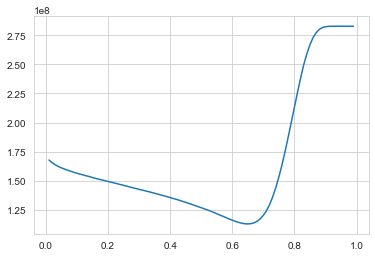

COST минимизирован около порога: 0.65 с ценой в: 112737600


In [90]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 1800], [6300, 1800]]) * 
                              metrics.confusion_matrix(y_test['is_churn'], np.where(predict_proba_lrm[:,1] > c, 1, 0))                              )
                       )
                )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('COST минимизирован около порога:', cutoffs[np.argmin(costs)], 'с ценой в:', np.min(costs))

In [93]:
is_churn_rate = len([x for x in y_test['is_churn'] if x==1])/len(y_test['is_churn'])
print(f"Доля реальных отточных клиентов на день предсказания:{is_churn_rate:.2f}")

Доля реальных отточных клиентов на день предсказания:0.45


Этот график показывает, что если мы дадим всем реально отточным клиентам (45%) стимул к удержанию, это обойдется нам примерно в 125 млн.руб. Однако с этой моделью и порогом 0,65 общая стоимость может быть минимизирована до 112 млн. руб. График также показывает, что бездействие будет иметь катастрофические последствия, поскольку расходы стремительно растут и в пике составляют более 275 млн. руб.

# 7. Финальный результат

Применим выводы по минимизации расходов, полученные после вычисления COST-функции и вычислим финальный результат предсказаний. 

In [94]:
final_predictions = np.where(predict_proba_lrm[:,1] > cutoffs[np.argmin(costs)],1,0)

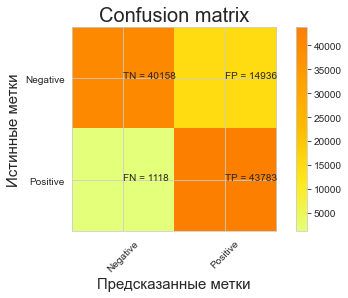

In [106]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """ Plot a confusion matrix"""
    classNames = ['Negative','Positive']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.tight_layout()
    plt.ylabel('Истинные метки', fontsize=15)
    plt.xlabel('Предсказанные метки',fontsize=15)
cm = metrics.confusion_matrix(y_test, final_predictions)
plot_confusion_matrix(cm)

In [109]:
print(f"Точность финальной модели: {metrics.accuracy_score(y_test,final_predictions):.4f}")

Точность финальной модели: 0.8395


# 7. Сохранение данных

Сохраним финальные данные в формате pickle для последующего использования.

In [110]:
path = str(workdir+'/data')
if not os.path.isdir(path):
    os.mkdir(path)
    print('Папка успешно создана!')
else:
    print('Папка уже существует')

Папка уже существует


In [112]:
X_train.to_pickle(path+'/X_train.pkl')
X_test.to_pickle(path+'/X_test.pkl')
y_train.to_pickle(path+'/y_train.pkl')
y_test.to_pickle(path+'/y_test.pkl')
np.save(path+'/predict_proba_lrm.npy', predict_proba_lrm)
np.save(path+'/final_predictions.npy', final_predictions)